In [46]:
# Req Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_ind, chi2_contingency, pearsonr, spearmanr
import xgboost as xgb 

## Manipulate Data

# Read csv into data frame
df = pd.read_csv('nyc_housing_base.csv')

# Fill missing values
df = df.fillna(0)
# drop rows with missing vals
df = df.dropna()

# PCA/Z-Score/etc


In [47]:
## Clean Data

# Remove dupped rows
df = df.drop_duplicates()


In [48]:
##  Numerical Computing

# Convert data frame to numpy array
np_array = df.to_numpy()

# Convert headers to python list
headers_list = df.columns.tolist()

# Define num of cols in csv file
num_cols = 19

# Dict that maps header name to numbered column
header_to_num = {header: number for header, number in zip(headers_list, range(num_cols))}

# Col data for building area, sales price, year built, borough x

# Independent var(s)
building_area_data = np_array[:, header_to_num["bldgarea"]]
yr_built_data = np_array[:, header_to_num["yearbuilt"]]
borough_x_data = np_array[:, header_to_num["borough_x"]]
latitude_data = np_array[:, header_to_num["latitude"]]

# num_floors_data = np_array[:, header_to_num["numfloors"]]
# longitude_data = np_array[:, header_to_num["longitude"]]

# Dependent var
sales_price_data = np_array[:, header_to_num["sale_price"]]

# Stats computations for building area (sq ft) (X)
mean_sales_price = np.mean(building_area_data)
med_sales_price = np.median(building_area_data)
std_sales_price = np.std(building_area_data)

# Stats computations for sales price (USD) (Y)
mean_sales_price = np.mean(sales_price_data)
med_sales_price = np.median(sales_price_data)
std_sales_price = np.std(sales_price_data)


In [63]:

# ML (sckit-learn)
# Feature(s)

# If using one feature, need to reshape array into single column 2D array
# X = building_area_data.reshape(-1, 1)
# X = burrow_x_data.reshape(-1, 1)

# IF using Z # of features, stack arrays as columns to form single, 2D array with Z columns
# 3 features used here, so kstack arrays as cols to form single, 2D array with 3 cols
X = np.column_stack((building_area_data, yr_built_data, borough_x_data, latitude_data))

# Target
y = sales_price_data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 10)

## Fit and predict with linear regression model
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()

# Use XBoost regressor for higher accuracy
from xgboost import XGBRegressor
model = XGBRegressor()

# Train model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Cross validation (5-fold)
# Returns numpy array of floating point scores
# Each element of returned array is perf metric of model for one specific test fold
cv_scores = cross_val_score(model, X_train, y_train, cv=5)

# OLS linear regression doesn't have hyperparams to tune

# Print individual scores for each score
print(f"Cross-validation scores: {cv_scores}")
# Print mean score and std across all folds
print(f"Mean CV Score: {np.mean(cv_scores):.2f}")
print(f"Standard Deviation of CV Scores: {np.std(cv_scores):.2f}")


Cross-validation scores: [0.25748587 0.26983303 0.28761649 0.23176277 0.25095391]
Mean CV Score: 0.26
Standard Deviation of CV Scores: 0.02


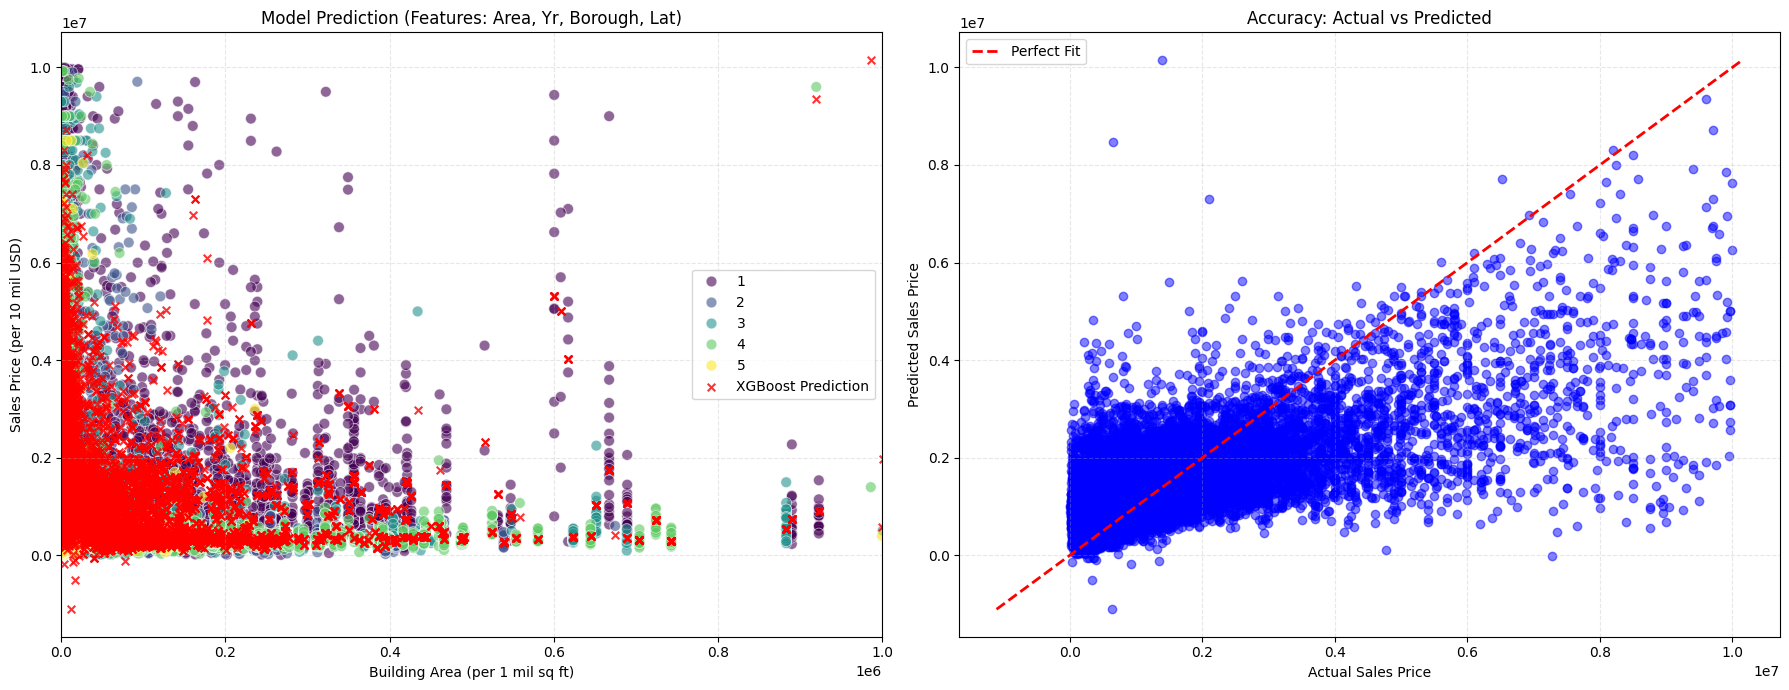

In [62]:
## Data Visualization (Matplotlib)

# Two subplots right next to each other
# Where left is feature slice, and right is accuracy check (actual vs predicted)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Left plot: feature slice (area vs price)
sns.scatterplot( 
    x = building_area_data,
    y = sales_price_data,
    hue = borough_x_data, # Coloring by borough is most intuitive
    palette = "viridis", # Color scheme for categories, Seaborn specific
    s = 60,
    alpha = 0.6, # For transparency
    ax = axes[0] # Set as first (left) subplot
)

# Generate predictions for full list; override previous y_pred for graphing purposes
y_pred = model.predict(X)

# Overlay new predictions (red Xs)
axes[0].scatter(
    building_area_data,
    y_pred,
    color = "red",
    marker = "x",
    s = 30,
    label = "XGBoost Prediction",
    alpha = 0.8,
)

# Title
axes[0].set_title(f"Model Prediction (Features: Area, Yr, Borough, Lat)")

# X axis
axes[0].set_xlabel("Building Area (per 1 mil sq ft)")
axes[0].set_xlim(0, 1000000)
# Y axis
axes[0].set_ylabel("Sales Price (per 10 mil USD)")

# Add legend and gridlines for visualization
axes[0].legend()
axes[0].grid(True, linestyle = "--", alpha = .3)


# Right plot: Accuracy check (actual vs predicted)

axes[1].scatter(sales_price_data, y_pred, color="blue", alpha=0.5)

# Calculate max and min vals (start and stop for predicted line) between actual and predicted
min_val = min(min(sales_price_data), min(y_pred))
max_val = max(max(sales_price_data), max(y_pred))

# Plot red dashed line from bottom left to top right
axes[1].plot([min_val, max_val], [min_val, max_val], "r--", linewidth = 2, label = "Perfect Fit")

axes[1].set_title(f"Accuracy: Actual vs Predicted")
axes[1].set_xlabel(f"Actual Sales Price")
axes[1].set_ylabel(f"Predicted Sales Price")

# Legend and gridlines for visualization; dashed line
axes[1].legend()
axes[1].grid(True, linestyle = "--", alpha = .3)

# Calculates padding, resizes, and aligns
plt.tight_layout()

# Show graph
plt.show()